In [1]:
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras import mixed_precision
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
mixed_precision.set_global_policy('mixed_float16')

2025-03-17 09:33:07.379868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 09:33:07.402657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 09:33:07.409472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 09:33:07.425532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 09:33:08.698219: W tensorflow/compiler/tf2

In [3]:
IMAGE_SIZE = (128, 128)  # Adjust based on your dataset
BATCH_SIZE = 16
# Update this to your dataset path
DATASET_PATH = "/home/jovyan/work/microorganism-dataset/ZKW_Data/test/images"


def load_image(filename):
    img = load_img(filename, target_size=IMAGE_SIZE)
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    return img


# Load all image file paths
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(
    DATASET_PATH) if f.endswith(('.jpg', '.png'))]

# Convert image paths to a TensorFlow dataset


def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming RGB images
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize
    return image


dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache().shuffle(len(image_paths)).batch(
    BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742203991.034044  205563 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742203991.037298  205563 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742203991.040018  205563 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742203991.190792  205563 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
def build_generator():
    model = Sequential([
        Dense(16*16*256, input_dim=128),
        LeakyReLU(0.2),
        Reshape((16, 16, 256)),
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        Conv2D(3, 5, padding='same', activation='sigmoid')  # 3 channels (RGB)
    ])
    return model


generator = build_generator()
generator.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │         9,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,102,531 (38.54 MB)

 Trainable params: 10,102,531 (38.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, 5, input_shape=(128, 128, 3), padding="same"),
        LeakyReLU(0.2),
        Dropout(0.4),
        Conv2D(128, 5, padding="same"),
        LeakyReLU(0.2),
        Dropout(0.4),
        Conv2D(256, 5, padding="same"),
        LeakyReLU(0.2),
        Dropout(0.4),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid"),
    ])
    return model


discriminator = build_discriminator()
discriminator.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 256)  │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4194304)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4194304)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │     4,194,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,223,553 (19.93 MB)

 Trainable params: 5,223,553 (19.93 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Improved Discriminator to better differentiate real vs fake
def build_discriminator(input_shape=(128, 128, 3)):
    model = Sequential(name="discriminator")
    # Note: Removing BatchNorm from the critic can help with WGAN stability.
    # Also removing dropout for clarity, but you can reintroduce it if overfitting.
    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    # No activation here for WGAN: unbounded output
    model.add(Dense(1))
    return model

In [7]:
class CustomGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        # random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
        random_latent_vectors = tf.random.normal(
            (batch_size, 128)) + (0.1 * tf.random.normal((batch_size, 128)))

        # Generate Fake Images
        fake_images = self.generator(random_latent_vectors, training=False)

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_labels = tf.ones_like(real_output) * 0.9
            fake_labels = tf.zeros_like(fake_output)

            d_loss = self.d_loss(real_labels, real_output) + \
                self.d_loss(fake_labels, fake_output)

        d_grads = d_tape.gradient(
            d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(
            zip(d_grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as g_tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_output = self.discriminator(fake_images, training=False)
            g_loss = self.g_loss(tf.ones_like(fake_output), fake_output)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [8]:
# g_opt = Adam(learning_rate=0.00005)
# d_opt = Adam(learning_rate=0.000001)
g_opt = Adam(learning_rate=0.0002, beta_1=0.5)
d_opt = Adam(learning_rate=0.0002, beta_1=0.5)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

gan = CustomGAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [9]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img


class GenerateImagesCallback(Callback):
    def __init__(self, num_images=3, latent_dim=128):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            (self.num_images, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        os.makedirs("generated_images", exist_ok=True)
        for i in range(self.num_images):
            img = array_to_img(generated_images[i])
            img.save(f"generated_images/generated_img_{epoch}_{i}.png")

# clear the output directory
!rm -rf generated_images
callback = GenerateImagesCallback()


In [10]:
gan.fit(dataset, epochs=1000, callbacks=[callback])

Epoch 1/1000


I0000 00:00:1742203998.872308  205772 service.cc:146] XLA service 0x5fe8da252d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742203998.872367  205772 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-03-17 09:33:19.011991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-17 09:33:19.582134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-03-17 09:33:22.911798: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,128,128,64]{3,2,1,0}, f16[128,5,5,64]{3,2,1,0}, f16[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - d_loss: 2.1299 - g_loss: 1.2764

2025-03-17 09:34:15.081148: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[15,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[15,128,128,64]{3,2,1,0}, f16[128,5,5,64]{3,2,1,0}, f16[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-17 09:34:18.041166: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.960241544s
Trying algorithm eng0{} for conv (f16[15,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[15,128,128,64]{3,2,1,0}, f16[128,5,5,64]{3,2,1,0}, f16[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backe

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 2.0686 - g_loss: 1.2462   

W0000 00:00:1742204096.095821  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.152501  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.153350  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.154139  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.154948  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.155749  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.156533  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.157503  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742204096.158276  205563 gp

14/14 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - d_loss: 2.0156 - g_loss: 1.2200
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - d_loss: 1.5367 - g_loss: 1.1286
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - d_loss: 1.2375 - g_loss: 0.9822
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - d_loss: 3.6061 - g_loss: 0.9055
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 10/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 11/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 17.5382 - g_loss: 1.1921e-07
Epoch 12/

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



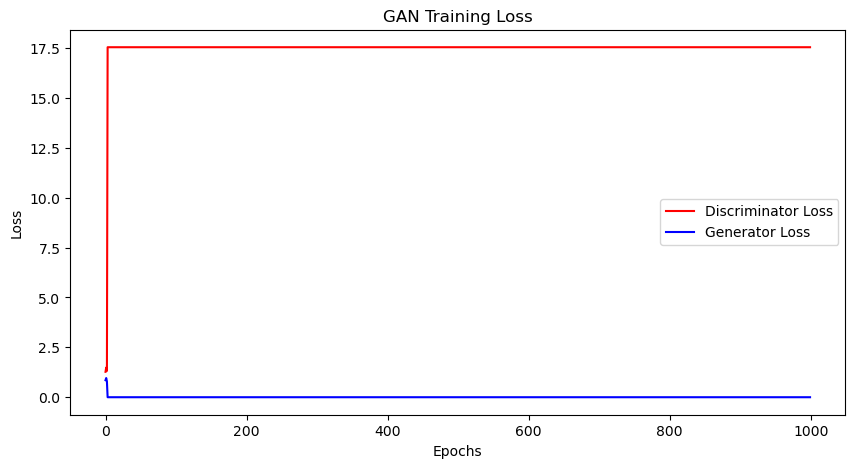

In [11]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(gan.history.history['d_loss'],
         label='Discriminator Loss', color='red')
plt.plot(gan.history.history['g_loss'], label='Generator Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

W0000 00:00:1742209528.909769  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.914790  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.918262  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.921383  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.924814  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.928237  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.931669  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.934089  205563 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742209528.936220  205563 gp

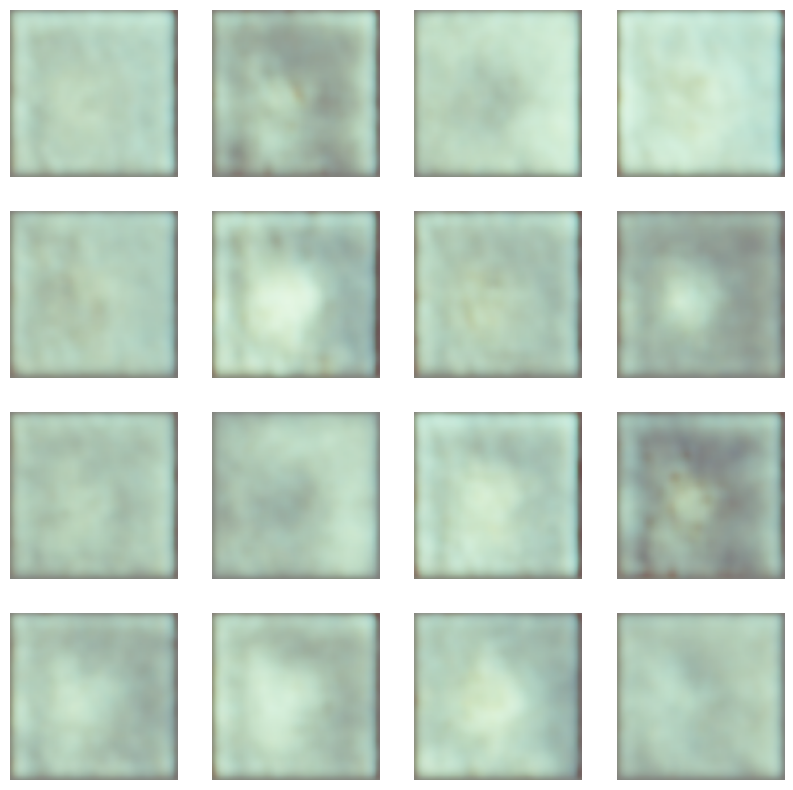

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Generate new images from the trained generator
num_samples = 16
latent_vectors = tf.random.normal((num_samples, 128))
generated_images = generator(latent_vectors, training=False)

# Convert to NumPy and ensure correct dtype
# Convert TensorFlow tensor to NumPy array
generated_images = generated_images.numpy()
# Ensure uint8 for visualization
generated_images = np.clip(generated_images * 255, 0, 255).astype(np.uint8)

# Plot generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        img_idx = i * 4 + j
        ax[i][j].imshow(generated_images[img_idx])  # Ensure correct format
        ax[i][j].axis('off')

plt.show()